In [1]:
import os
os.chdir("/content/drive/My Drive/Humana Google Colab")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("2020_Competition_Training (1).csv")
df["train"] = 1
df_hold = pd.read_csv("2020_Competition_Holdout .csv")
df_hold["train"] = 0
df_hold["transportation_issues"] = None
df_all = pd.concat([df, df_hold])
df_all.reset_index(inplace=True)
df_all.shape #87253 rows with 828 features

(87253, 828)

In [3]:
df_description = pd.read_excel("final for feature engineering_2.xls")
columns_left = df_description[df_description["Target_col"]==1]["index"].tolist()+["train"]
df_all = df_all[columns_left] #488 features
df = df_all[df_all["train"]==1].copy()

### Missing Values

In [4]:
df_columns = df_all.columns.tolist()
df_columns.remove("transportation_issues")

#Columns with missing value
columns_with_missing = []
for column in df_columns:
    if df_all[column].isnull().sum()>0:
        columns_with_missing.append({"column":column, "missing":df_all[column].isnull().sum()})

df_missing_distribution = pd.DataFrame.from_dict(columns_with_missing)
df_missing_distribution.sort_values("missing",ascending=False).reset_index(inplace=True)
from sklearn.impute import SimpleImputer
# rank 1 blood fat screen or control
# rank 2 data from cons about demos
# rank 3 cms data insurance factor data.
imputer_frequent = SimpleImputer(strategy="most_frequent")
for column in df_missing_distribution["column"]:
    try:
        if df_all[column].nunique()>=30:
            df_all[column].fillna(df_all[column].mean(),inplace=True)
        else:
            df_all[column].fillna(df_all[column].value_counts().index[0],inplace=True)
    except:
        print(column)

## Variable Types and Manipulation

In [5]:
column_types = pd.DataFrame(df_all.dtypes).reset_index()
object_columns = column_types[column_types[0]=="object"]["index"].tolist()
float_columns = column_types[column_types[0]=="float64"]["index"].tolist()
int_columns = column_types[column_types[0]=="int64"]["index"].tolist()
print("object:{},  float:{},  int:{}".format(len(object_columns),len(float_columns),len(int_columns)))

object:20,  float:393,  int:76


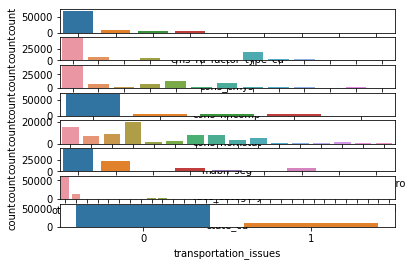

<Figure size 7200x28800 with 0 Axes>

In [6]:
object_dataframe = pd.DataFrame(df_all[object_columns].nunique()>=5).reset_index()
multi_object_columns = object_dataframe[object_dataframe[0]==True]["index"].tolist()+["transportation_issues"]
df_multi_object = df_all[multi_object_columns] #we have eight variabels including t_i

fig, axs = plt.subplots(nrows=8)
plt.figure(figsize=(100,400))
for i in range(8):
  sns.countplot(df_all[df_multi_object.columns[i]], ax=axs[i])

In [7]:
def get_proportion(group):
  return pd.DataFrame(group.sum()/group.count()).sort_values(by="transportation_issues")
group_by_object_list = []
for i in range(7):
  group_by_object_list.append(df_multi_object.groupby\
                              (df_multi_object[df_multi_object.columns[i]])["transportation_issues"])
  #print(get_proportion(group_by_object_list[i]))

#for 1: group * and CN together.
#for 2: set * as 7 and covert into int.
#leave the rest for decision tree judge.

df_all["cms_ra_factor_type_cd"].replace("*","CN",inplace=True)
df_all["cons_cmys"].replace("*",7,inplace=True)
df_all["cons_cmys"].astype(int)

0        4
1        4
2        6
3        4
4        4
        ..
87248    5
87249    3
87250    4
87251    4
87252    3
Name: cons_cmys, Length: 87253, dtype: int64

## Split the data

In [8]:
#Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,df.transportation_issues, test_size=0.3,
                                                    random_state=42)
X_train.shape, X_test.shape

((48700, 489), (20872, 489))

## Encode the categorical features

In [9]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 4.8MB/s 


In [10]:
import category_encoders as ce
object_columns.remove("transportation_issues")
woe_enc = ce.WOEEncoder(cols=object_columns).fit(X_train,y_train)
df_all = woe_enc.transform(df_all)

## Remove highly correlated variables

In [11]:
corr = df_all.corr()

In [12]:
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [13]:
df_all.drop(correlated_features, axis=1, inplace=True)

## Save the new data

In [14]:
df = df_all[df_all["train"]==1].copy()
#df.to_csv("df_train_after_FE.csv")
df.drop("train", axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df,\
                                                    df.transportation_issues, test_size=0.3,
                                                    random_state=42)

In [16]:
#Not sure about this step. But it is very important. Let's leave it for here.
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer().fit(X_train)
# X_train = pt.transform(X_train)

# pt = PowerTransformer().fit(X_test)
# X_test = pt.transform(X_test)

## Upsampling

In [17]:
from sklearn.utils import resample
X = X_train.copy()
# separate minority and majority classes
wo_tran = X[X["transportation_issues"]==0]
tran = X[X["transportation_issues"]==1]

# upsample minority
tran_upsampled = resample(tran,
                          replace=True, # sample with replacement
                          n_samples=len(wo_tran), # match number in majority class
                          random_state=1) # reproducible results

upsampled = pd.concat([wo_tran,tran_upsampled])

# check new class counts
print(upsampled["transportation_issues"].value_counts())

X_train = upsampled.drop("transportation_issues",axis=1)
y_train = upsampled["transportation_issues"].astype(int)
X_test = X_test.drop("transportation_issues", axis=1)
y_test = y_test.astype(int)

1    41536
0    41536
Name: transportation_issues, dtype: int64


## Recursive Feature Elimination

In [18]:
!git clone https://github.com/ashishpatel26/Amazing-Feature-Engineering.git
!git pull

fatal: destination path 'Amazing-Feature-Engineering' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from feature_selection import hybrid
features_to_keep = hybrid.recursive_feature_elimination_rf(X_train=X_train,
                                                           y_train=y_train,
                                                           X_test=X_test,
                                                           y_test=y_test,
                                                           tol=0.005)


## Scaling

In [24]:
pd.DataFrame(features_to_keep).to_csv("features kept2.csv")

In [32]:
X_train.shape

(83072, 477)

In [30]:
#Robust Scaler
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)
X_train = rs.transform(X_train)

rs = RobustScaler().fit(X_test)
X_test = rs.transform(X_test)

## Basic Logistic Model - No Improvement Found Yet.

In [31]:
#Lets do a simple logistic regression here first 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = "lbfgs",random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

ValueError: ignored

In [ ]:
y_train_pred = clf.predict(X_train)
(y_train_pred == y_train).mean()
roc_auc_score(y_train_pred, y_train)
# it is underfitting

In [ ]:
#Accuracy
(y_test==y_pred).mean() #Underfitting

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
        n_estimators=5000,
        max_depth=3, 
        learning_rate=0.01)

xgboost_model = model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print((y_test==y_pred).mean())